## Q1  



### What is PCA?

PCA is a method to **reduce dimensions** while keeping as much information (variance) as possible.  

Steps in PCA:

1. **Center the data**: shift the dataset so its mean is at zero.  
2. **Find covariance matrix**: shows how the two features vary together.  
3. **Eigen decomposition**: find eigenvectors (directions) and eigenvalues (amount of variance in that direction).  
4. **Sort them**: bigger eigenvalue = more important component.  
5. **Project data**: represent data in these new directions.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_csv(path):
    try:
        X = np.loadtxt(path, delimiter=',')
    except:
        X = np.genfromtxt(path, delimiter=',', skip_header=1)
    if X.ndim == 1:
        X = X.reshape(-1, X.shape[0])
    return X

X = load_csv('dataset1-assignment1 - Sheet1.csv')
print(f"Dataset shape: {X.shape}")

Dataset shape: (1000, 2)


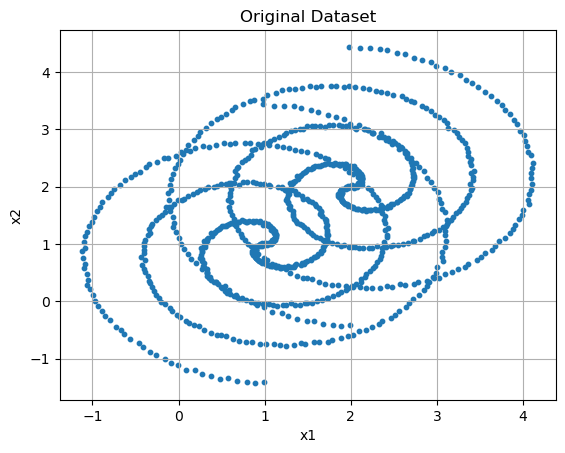

In [3]:
plt.scatter(X[:,0], X[:,1], s=10)
plt.title("Original Dataset")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.show()

### Observations from the Original Dataset

- The points are not random, they are forming **spiral type curves**.  
- I can see **loops going around the center** again and again.  
- The data looks like it has **many circular layers**, all twisted together.  
- The points are kind of evenly spaced on the curves.  
- From the axis, the values go from around **-1 up to 4** on both sides.  

In [4]:
def pca_from_scratch(X):
    # Step 1: center the data
    Xc = X - np.mean(X, axis=0)
    
    # Step 2: covariance matrix
    cov = (Xc.T @ Xc) / (Xc.shape[0] - 1)
    
    # Step 3: eigen decomposition for finding eignevalues
    evals, evecs = np.linalg.eigh(cov)
    
    # Step 4: sort eigenvalues (descending) as wwe want max eignevalues 
    idx = np.argsort(evals)[::-1]
    evals, evecs = evals[idx], evecs[:, idx]
    
    # Step 5: explained variance ratio
    evr = evals / np.sum(evals)
    
    # Step 6: project data
    scores = Xc @ evecs
    return evals, evecs, evr, scores

In [5]:
evals, evecs, evr, scores = pca_from_scratch(X)

print("Eigenvalues:", evals)
print("Explained Variance Ratio:", evr)

Eigenvalues: [1.63395882 0.86468897]
Explained Variance Ratio: [0.65393723 0.34606277]


### PCA Observations:
- The first eigenvalue is larger, meaning the **first component** explains most of the variance.  
- In our dataset:
  - PC1 explains ~65% of variance.  
  - PC2 explains ~35% of variance.  

So PCA already reduces most of the information into one direction.


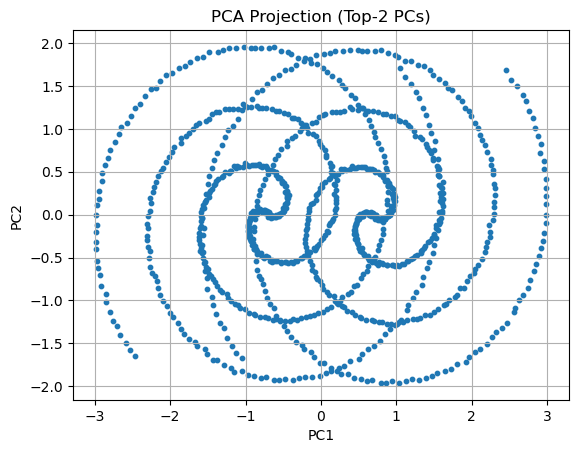

In [6]:
plt.scatter(scores[:,0], scores[:,1], s=10)
plt.title("PCA Projection (Top-2 PCs)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

### Why Kernel PCA?

Normal PCA is **linear**, so it works best when the data spreads out in straight directions.  
But if the data is shaped like a **curve, circle, or spiral**, PCA won’t describe it properly.  

Kernel PCA fixes this by using a **kernel**:
- A kernel is just a way to check how similar two points are.  
- With the kernel trick, it feels like the data is moved into a higher space where it becomes easier to separate.  

---

### Steps in Kernel PCA:
1. Make the kernel matrix \(K\).  
2. Adjust (center) the kernel so it’s balanced like mean zero in that space.  
3. Do eigen decomposition on the kernel matrix.  
4. Take the top components and project the data onto them.  


### Kernels we will test:
- Linear  
- Polynomial 
- RBF 

**Linear Kernel**:  

  $$
  K(x,y) = x \cdot y
  $$

In [7]:
def linear_kernel(X):
    return X @ X.T

**Polynomial Kernel**:  

  $$
  K(x,y) = (1 + x \cdot y)^d
  $$

In [8]:
def polynomial_kernel(X, degree=3, gamma=None, coef0=1):
    if gamma is None:
        gamma = 1.0 / X.shape[1]
    return (gamma * (X @ X.T) + coef0) ** degree

**RBF (Gaussian) Kernel**:  

  $$
  K(x,y) = \exp\left(-\frac{\|x-y\|^2}{2\sigma^2}\right)
  $$

In [9]:
def rbf_kernel(X, sigma=1.0):
    sq_dists = np.sum(X**2, axis=1)[:, None] + np.sum(X**2, axis=1)[None, :] - 2 * (X @ X.T)
    return np.exp(-sq_dists / (2 * sigma**2))

In [10]:
def center_kernel(K):
    n = K.shape[0]
    one_n = np.ones((n,n)) / n
    return K - one_n @ K - K @ one_n + one_n @ K @ one_n

In [11]:
# KPCA stands for kernal PCA
def kpca(K, n_components=2):
    
    evals, evecs = np.linalg.eigh(K)
    idx = np.argsort(evals)[::-1]
    
    evals, evecs = evals[idx], evecs[:, idx]
    evals, evecs = evals[:n_components], evecs[:, :n_components]
    
    alphas = np.zeros_like(evecs)
    for i in range(evecs.shape[1]):
        v = evecs[:, i]
        norm_factor = np.sqrt(v.T @ K @ v)
        alphas[:, i] = v / norm_factor if norm_factor > 1e-12 else v
    
    projections = K @ alphas
    for i in range(projections.shape[1]):
        if evals[i] > 1e-12:
            projections[:, i] /= np.sqrt(evals[i])
    return evals, projections

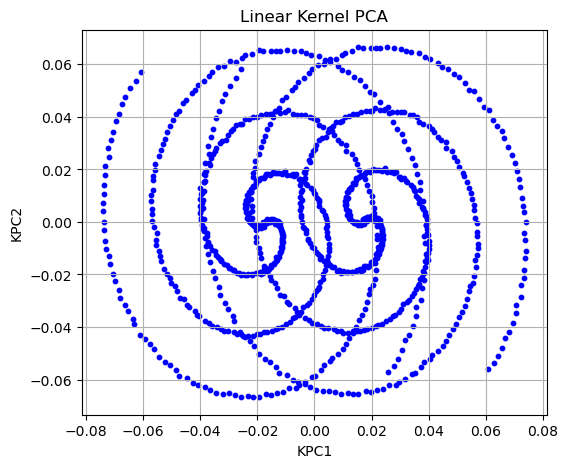

In [12]:
# --- Linear Kernel PCA ---
plt.figure(figsize=(6,5))
K = linear_kernel(X)
Kc = center_kernel(K)
evals, proj = kpca(Kc, n_components=2)
plt.scatter(proj[:,0], proj[:,1], s=10, c='b')
plt.title("Linear Kernel PCA")
plt.xlabel("KPC1")
plt.ylabel("KPC2")
plt.grid(True)
plt.show()


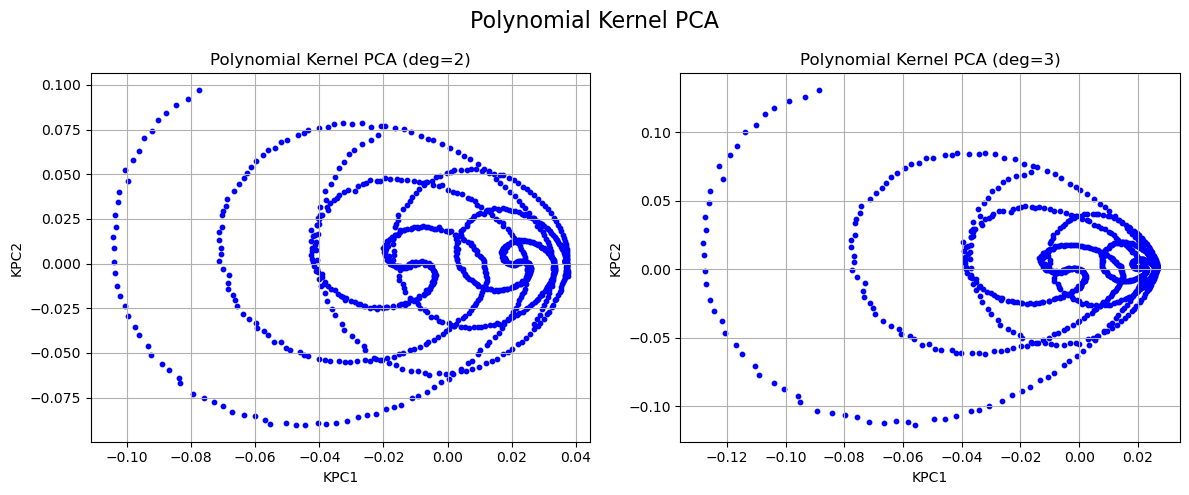

In [13]:
# --- Polynomial Kernel PCA ---
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Degree 2
K = polynomial_kernel(X, degree=2)
Kc = center_kernel(K)
evals, proj = kpca(Kc, n_components=2)

axes[0].scatter(proj[:,0], proj[:,1], s=10, c='b')
axes[0].set_title("Polynomial Kernel PCA (deg=2)")
axes[0].set_xlabel("KPC1")
axes[0].set_ylabel("KPC2")
axes[0].grid(True)

# Degree 3
K = polynomial_kernel(X, degree=3)
Kc = center_kernel(K)
evals, proj = kpca(Kc, n_components=2)

axes[1].scatter(proj[:,0], proj[:,1], s=10, c='b')
axes[1].set_title("Polynomial Kernel PCA (deg=3)")
axes[1].set_xlabel("KPC1")
axes[1].set_ylabel("KPC2")
axes[1].grid(True)

plt.suptitle("Polynomial Kernel PCA", fontsize=16)
plt.tight_layout()
plt.show()


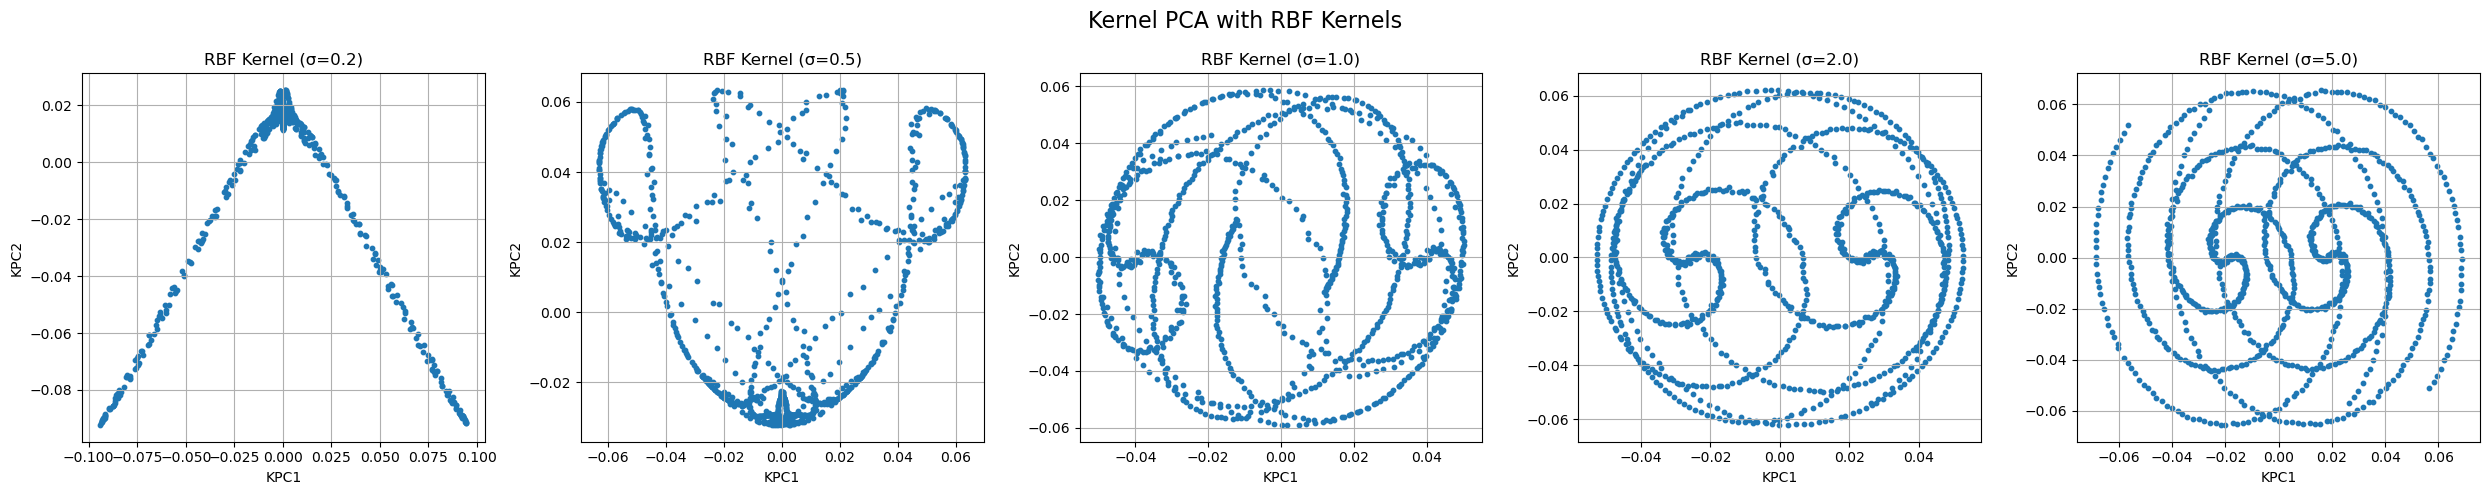

In [14]:
# --- RBF Kernel PCA ---
rbf_sigmas = [0.2,0.5, 1.0, 2.0, 5.0]
fig, axes = plt.subplots(1, 5, figsize=(25,5))

for ax, s in zip(axes, rbf_sigmas):
    K = rbf_kernel(X, sigma=s)
    Kc = center_kernel(K)
    evals, proj = kpca(Kc, n_components=2)
    
    ax.scatter(proj[:,0], proj[:,1], s=10)
    ax.set_title(f"RBF Kernel (σ={s})")
    ax.set_xlabel("KPC1")
    ax.set_ylabel("KPC2")
    ax.grid(True)

plt.suptitle("Kernel PCA with RBF Kernels", fontsize=16)
plt.tight_layout()
plt.show()


### Observations:

- **Linear Kernel:** Same as PCA (linear projection).  
- **Polynomial Kernel:** Changes structure, not always useful.  
- **RBF Kernel:** Best for nonlinear shapes.  
  - σ too small (0.1, 0.2) → projections look scattered.  
  - σ too big (2.0) → everything looks smooth, details lost.  
  - σ ~ 0.5–1.0 → captures the curved patterns nicely.  

---

### ✅ Final Answer:
With proper kernel centering, the **RBF kernel (σ ~0.5–1.0)** is the best choice for this dataset.
